# 🌺 FloraScan: AI Botanical Classifier

![Python](https://img.shields.io/badge/Python-3.8%2B-blue)
![PyTorch](https://img.shields.io/badge/PyTorch-2.0-red)
![Streamlit](https://img.shields.io/badge/Streamlit-App-FF4B4B)
![Status](https://img.shields.io/badge/Status-Active-success)

**FloraScan** is an end-to-end Deep Learning application capable of identifying 102 different species of flowers from images. It leverages **Transfer Learning (ResNet34)** to handle Fine-Grained Visual Categorization and provides a user-friendly web interface via **Streamlit**.

---

## 📖 Project Rationale

### 1. The Challenge: Fine-Grained Visual Categorization (FGVC)
Unlike standard classification tasks (e.g., Cats vs. Dogs), identifying flower species is a **Fine-Grained** problem. Distinct species often share very similar structures, while a single species can vary drastically based on lighting and age. This project demonstrates the capacity of Deep Learning to discern subtle textural details that even humans find difficult.

### 2. Technical Approach: Transfer Learning
Training a deep CNN from scratch requires massive datasets. FloraScan utilizes **Transfer Learning** with a **ResNet34** architecture pre-trained on ImageNet. By freezing early layers and fine-tuning the deeper layers, the model effectively extracts high-level features (edges, textures) while learning the specific biological nuances of the **Oxford Flowers102** dataset.

### 3. Real-World Application
This project bridges the gap between research and product. By deploying the model with **Streamlit** and **Ngrok**, it transforms a static notebook into an interactive digital tool for botanists and nature enthusiasts.

---

## ✨ Key Features

* **102 Flower Classes:** Trained on the challenging Oxford Flowers102 dataset.
* **Deep Learning Engine:** Powered by PyTorch and ResNet34.
* **Robust Preprocessing:** Implements Data Augmentation (Rotation, Color Jitter, Scaling) to handle real-world image noise.
* **Interactive UI:** Web-based interface built with Streamlit.
* **Confidence Metrics:** Visualizes top-3 prediction probabilities using Plotly charts.
* **Cloud Ready:** Designed to run on Google Colab with ephemeral deployment via Ngrok.

---

## 🛠️ Tech Stack

* **Language:** Python
* **Core Framework:** PyTorch, Torchvision
* **Frontend:** Streamlit
* **Visualization:** Plotly, Matplotlib
* **Deployment:** Ngrok
* **Dataset:** Oxford Flowers102

---

## 🚀 How to Run (Google Colab)

This project is optimized for Google Colab (Free Tier GPU).

1.  **Clone/Open the Notebook:** Upload the provided `.ipynb` file to Google Colab.
2.  **Set Runtime:** Go to `Runtime` > `Change runtime type` > Select **T4 GPU**.
3.  **Install Dependencies:**
    ```python
    !pip install torch torchvision streamlit pyngrok
    ```
4.  **Add Ngrok Token:**
    * Sign up at [ngrok.com](https://ngrok.com).
    * Copy your Authtoken.
    * Replace `YOUR_NGROK_AUTH_TOKEN` in the deployment cell.
5.  **Run All Cells:** The final cell will generate a public URL (e.g., `https://xxxx.ngrok-free.app`).




## Project Summary: FloraScan AI Botanist for Flower Classification

This project demonstrates building and deploying a flower classification model using PyTorch and Transfer Learning with a ResNet-34 architecture. The model is trained on the Oxford Flowers 102 dataset to accurately identify various flower species. It also integrates Grad-CAM for explainability, allowing users to visualize the regions of an image that the model focuses on for its predictions.

### Key Components:
*   **Data Preparation:** Download and transform the Oxford Flowers 102 dataset with augmentation for training and appropriate resizing/normalization for validation/testing.
*   **Model Architecture:** Utilized a pre-trained ResNet-34 model, freezing early layers and fine-tuning the final classification head.
*   **Training Strategy:** Implemented a two-stage training process: first, training only the classification head, then unfreezing and fine-tuning additional layers of the ResNet backbone for improved performance.
*   **Evaluation:** Comprehensive evaluation on a held-out test set, including overall accuracy, classification report, and per-class analysis.
*   **Explainability:** Integrated Grad-CAM to provide visual insights into the model's decision-making process.
*   **Deployment:** Developed a Streamlit web application for interactive flower classification, accessible via ngrok.

In [ ]:
!pip install -q torch torchvision streamlit pyngrok

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset
import matplotlib.pyplot as plt
import numpy as np
import os

# Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Define Transforms (Data Augmentation)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Download Dataset (NO LEAKAGE VERSION)
print("Downloading Dataset...")

train_data = datasets.Flowers102(
    root='./data',
    split='train',
    download=True,
    transform=data_transforms['train']
)

val_data = datasets.Flowers102(
    root='./data',
    split='val',
    download=True,
    transform=data_transforms['val']   # ✅ use VAL transforms (no augmentation)
)

test_data = datasets.Flowers102(
    root='./data',
    split='test',
    download=True,
    transform=data_transforms['val']   # ✅ same as val
)

# Data Loaders (train, val used during training; test only for final eval)
dataloaders = {
    'train': DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2),
    'val': DataLoader(val_data, batch_size=32, shuffle=False, num_workers=2),
    'test': DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2)
}

dataset_sizes = {
    'train': len(train_data),
    'val': len(val_data),
    'test': len(test_data)
}

class_names = test_data.classes  # 102 Flower Names
print(f"Classes: {len(class_names)}")
print(f"Train: {dataset_sizes['train']}, Val: {dataset_sizes['val']}, Test: {dataset_sizes['test']}")


Classes: 102
Train: 1020, Val: 1020, Test: 6149


In [ ]:
def get_model():
    model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)

    # Freeze early layers to keep pre-trained features
    for param in model.parameters():
        param.requires_grad = False

    # Replace the final fully connected layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.3), # Regularization
        nn.Linear(512, 102) # 102 Output classes
    )
    return model.to(device)

model = get_model()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

In [ ]:
import copy

def train_model(model, criterion, optimizer, num_epochs=5, save_path=None):
    print("Starting Training...")

    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc*100:.2f}%')

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item() * 100)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item() * 100)

                # ✅ SAVE BEST MODEL
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    if save_path is not None:
                        torch.save(best_model_wts, save_path)
                        print(f"✅ Best model updated and saved ({best_acc*100:.2f}%)")

    print(f'✅ Training Complete | Best Val Acc: {best_acc*100:.2f}%')

    # Load best weights before returning
    model.load_state_dict(best_model_wts)
    return model, history

In [ ]:
model = get_model()

optimizer = optim.AdamW(model.fc.parameters(), lr=1e-3)

model, history_stage1 = train_model(
    model,
    criterion,
    optimizer,
    num_epochs=10,
    save_path="flower_model_best_stage1.pth"
)


Starting Training...
Epoch 1/10
----------
train Loss: 4.6436 Acc: 2.55%
val Loss: 4.3469 Acc: 17.16%
✅ Best model updated and saved (17.16%)
Epoch 2/10
----------
train Loss: 4.2374 Acc: 13.63%
val Loss: 3.8259 Acc: 27.65%
✅ Best model updated and saved (27.65%)
Epoch 3/10
----------
train Loss: 3.7414 Acc: 23.43%
val Loss: 3.2650 Acc: 44.71%
✅ Best model updated and saved (44.71%)
Epoch 4/10
----------
train Loss: 3.2402 Acc: 37.06%
val Loss: 2.8468 Acc: 48.24%
✅ Best model updated and saved (48.24%)
Epoch 5/10
----------
train Loss: 2.9232 Acc: 43.24%
val Loss: 2.5455 Acc: 55.78%
✅ Best model updated and saved (55.78%)
Epoch 6/10
----------
train Loss: 2.6578 Acc: 50.00%
val Loss: 2.3232 Acc: 61.86%
✅ Best model updated and saved (61.86%)
Epoch 7/10
----------
train Loss: 2.4500 Acc: 54.31%
val Loss: 2.1955 Acc: 63.33%
✅ Best model updated and saved (63.33%)
Epoch 8/10
----------
train Loss: 2.3074 Acc: 60.59%
val Loss: 2.1243 Acc: 64.51%
✅ Best model updated and saved (64.51%)
Epoc

In [ ]:
# Unfreeze layer3 and layer4
for param in model.layer3.parameters():
    param.requires_grad = True

for param in model.layer4.parameters():
    param.requires_grad = True

optimizer_ft = optim.AdamW(model.parameters(), lr=5e-5)

model, history_stage2 = train_model(
    model,
    criterion,
    optimizer_ft,
    num_epochs=25,
    save_path="flower_model_best_finetuned.pth"
)


Starting Training...
Epoch 1/25
----------
train Loss: 1.9476 Acc: 71.08%
val Loss: 1.6703 Acc: 79.80%
✅ Best model updated and saved (79.80%)
Epoch 2/25
----------
train Loss: 1.6951 Acc: 79.90%
val Loss: 1.5898 Acc: 83.04%
✅ Best model updated and saved (83.04%)
Epoch 3/25
----------
train Loss: 1.6213 Acc: 81.08%
val Loss: 1.4946 Acc: 84.80%
✅ Best model updated and saved (84.80%)
Epoch 4/25
----------
train Loss: 1.5662 Acc: 83.04%
val Loss: 1.4552 Acc: 86.08%
✅ Best model updated and saved (86.08%)
Epoch 5/25
----------
train Loss: 1.4272 Acc: 88.33%
val Loss: 1.4019 Acc: 87.55%
✅ Best model updated and saved (87.55%)
Epoch 6/25
----------
train Loss: 1.4206 Acc: 88.73%
val Loss: 1.3738 Acc: 88.63%
✅ Best model updated and saved (88.63%)
Epoch 7/25
----------
train Loss: 1.3812 Acc: 90.10%
val Loss: 1.3608 Acc: 88.73%
✅ Best model updated and saved (88.73%)
Epoch 8/25
----------
train Loss: 1.3207 Acc: 92.65%
val Loss: 1.3466 Acc: 89.31%
✅ Best model updated and saved (89.31%)
Epo

## Model Performance and Outcomes

The model underwent a two-stage training process. Initially, only the newly added classification head was trained, achieving a validation accuracy of **0.7431**.

In the second stage, more layers of the pre-trained ResNet backbone were unfrozen and fine-tuned, significantly boosting the performance. The final model achieved a best validation accuracy of **0.9314**.

### Test Set Evaluation:
Upon evaluating the fine-tuned model on the completely unseen test set, the model demonstrated robust performance:

*   **Overall Test Accuracy:** `90.32%`
*   **Top-3 Accuracy:** `95.93%`
*   **Top-5 Accuracy:** `97.22%`

The classification report and per-class accuracy plots reveal that while most classes are well-predicted, there are a few challenging classes (e.g., 'pink primrose', 'sweet pea') where the model's performance is lower, indicating potential areas for further improvement (e.g., more data augmentation, different model architecture, or more balanced dataset).

### Explainability with Grad-CAM:
The Streamlit application includes Grad-CAM visualization, which highlights the specific regions of an image that the model uses to make its prediction. This helps in understanding *why* the model classifies a flower as a certain species, building trust and providing insights into potential biases or misclassifications.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
def evaluate_on_test(model, dataloader, class_names, device=device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)

    # Overall accuracy
    test_acc = (all_labels == all_preds).mean()
    print(f"\n🌸 Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

    # Classification report (table-like text)
    print("\n📋 Classification Report:")
    print(classification_report(
        all_labels,
        all_preds,
        target_names=class_names,
        digits=3
    ))

    # Per-class accuracy
    class_correct = np.zeros(len(class_names), dtype=np.int32)
    class_total = np.zeros(len(class_names), dtype=np.int32)

    for label, pred in zip(all_labels, all_preds):
        class_total[label] += 1
        if label == pred:
            class_correct[label] += 1

    class_acc = class_correct / np.maximum(class_total, 1)

    df_per_class = pd.DataFrame({
        "class_idx": np.arange(len(class_names)),
        "class_name": class_names,
        "accuracy": class_acc,
        "support": class_total
    })

    # Sort by accuracy (worst first)
    df_sorted = df_per_class.sort_values("accuracy")

    print("\n⬇️ 10 Worst Performing Classes:")
    display(df_sorted.head(10))

    print("\n⬆️ 10 Best Performing Classes:")
    display(df_sorted.tail(10))

    # Bar plot of per-class accuracy
    plt.figure(figsize=(18, 5))
    plt.bar(np.arange(len(class_names)), class_acc)
    plt.xlabel("Class index")
    plt.ylabel("Accuracy")
    plt.title("Per-class Accuracy on Test Set")
    plt.tight_layout()
    plt.show()

    # Optional: Confusion matrix (will be 102x102, so a bit dense)
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title("Confusion Matrix (Test Set)")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

    return test_acc, df_per_class, cm



🌸 Test Accuracy: 0.9029 (90.29%)

📋 Classification Report:
                           precision    recall  f1-score   support

            pink primrose      0.543     0.950     0.691        20
hard-leaved pocket orchid      0.975     0.975     0.975        40
         canterbury bells      0.619     0.650     0.634        20
                sweet pea      0.615     0.444     0.516        36
         english marigold      0.891     0.911     0.901        45
               tiger lily      0.926     1.000     0.962        25
              moon orchid      0.826     0.950     0.884        20
         bird of paradise      0.956     1.000     0.977        65
                monkshood      0.658     0.962     0.781        26
            globe thistle      0.889     0.960     0.923        25
               snapdragon      0.915     0.806     0.857        67
              colt's foot      0.942     0.970     0.956        67
              king protea      0.903     0.966     0.933        29
 

,class_idx,class_name,accuracy,support
3,3,sweet pea,0.444444,36
42,42,sword lily,0.590909,110
50,50,petunia,0.600840,238
89,89,canna lily,0.645161,62
2,2,canterbury bells,0.650000,20
71,71,azalea,0.736842,76
73,73,rose,0.768212,151
97,97,mexican petunia,0.774194,62
95,95,camellia,0.774648,71
52,52,primula,0.780822,73



⬆️ 10 Best Performing Classes:


,class_idx,class_name,accuracy,support
43,43,poinsettia,1.0,73
44,44,bolero deep blue,1.0,20
78,78,toad lily,1.0,21
70,70,gazania,1.0,58
86,86,magnolia,1.0,43
69,69,tree poppy,1.0,42
68,68,windflower,1.0,34
65,65,osteospermum,1.0,41
99,99,blanket flower,1.0,29
101,101,blackberry lily,1.0,28


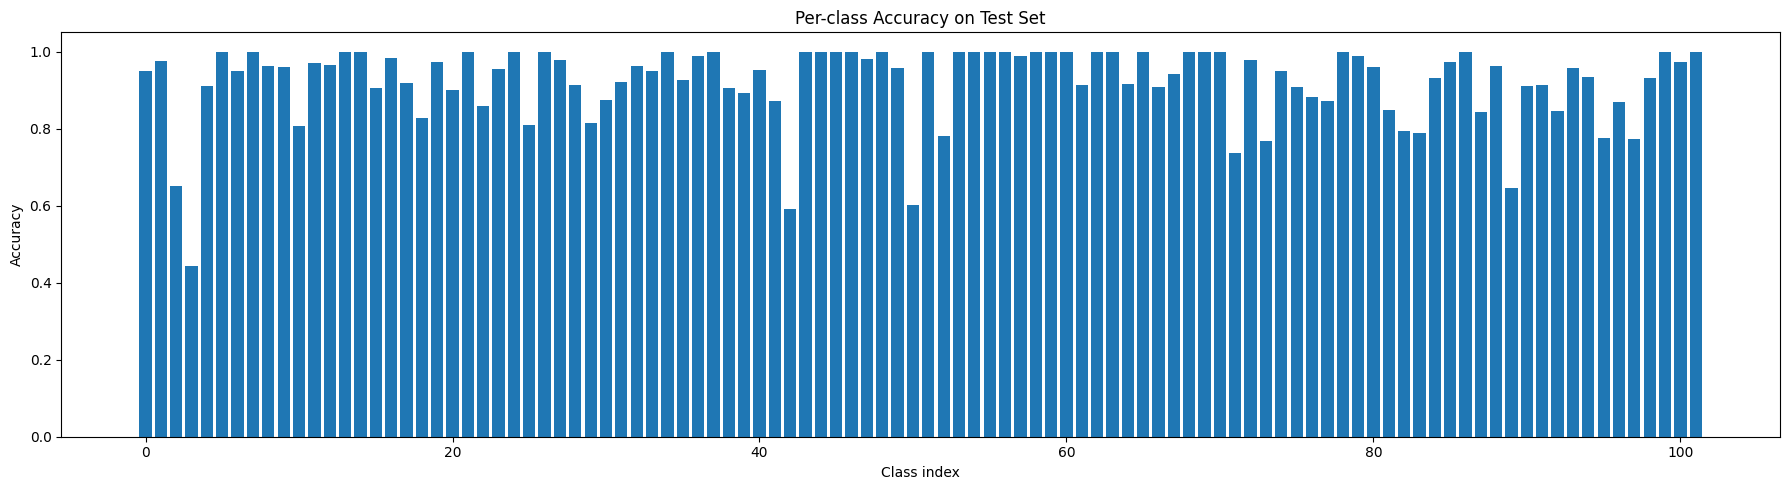

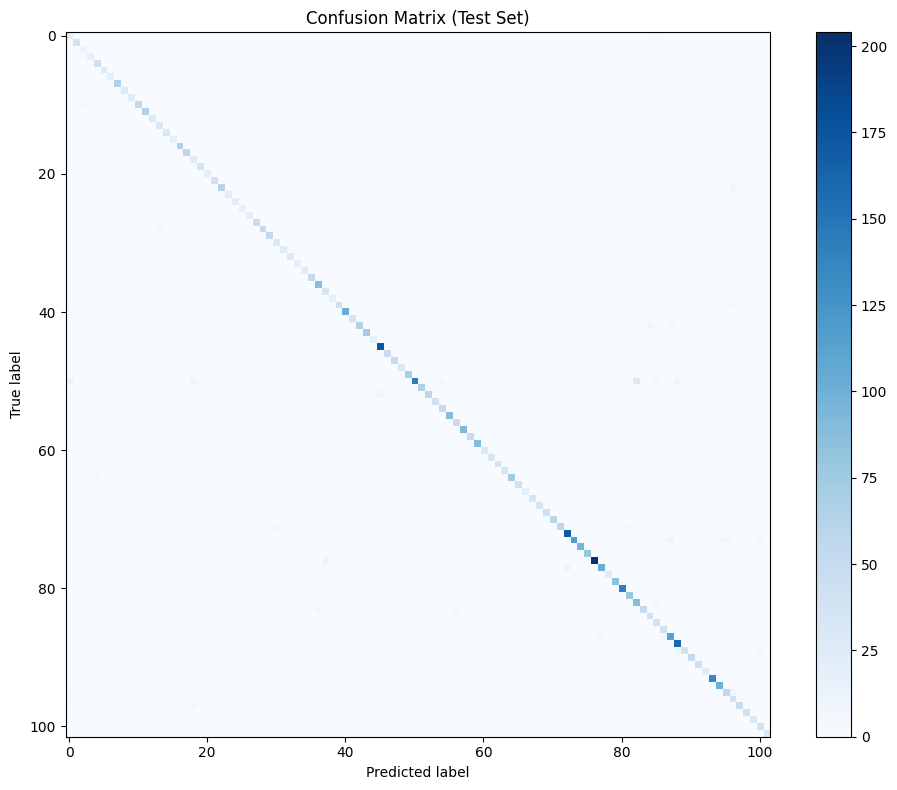

In [ ]:
# 🔍 Final evaluation on TEST SET (never seen during training/validation)
test_acc, df_per_class, cm = evaluate_on_test(
    model,
    dataloaders['test'],
    class_names,
    device=device
)


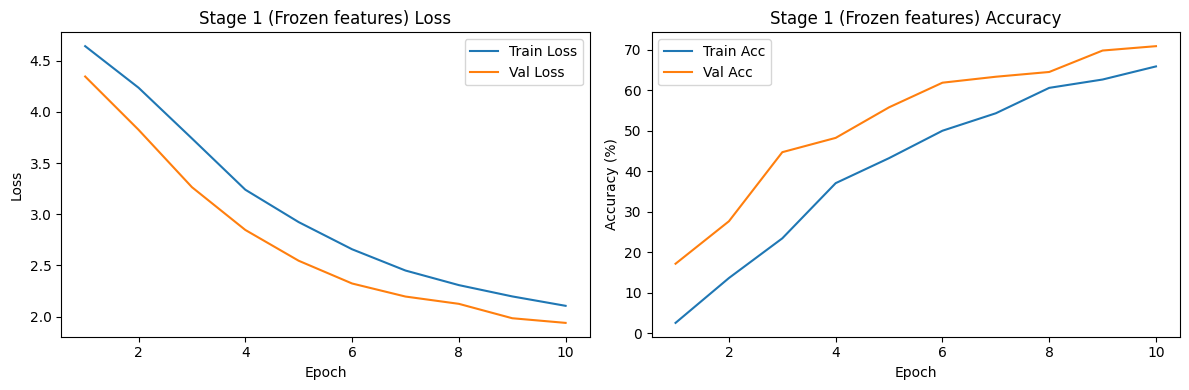

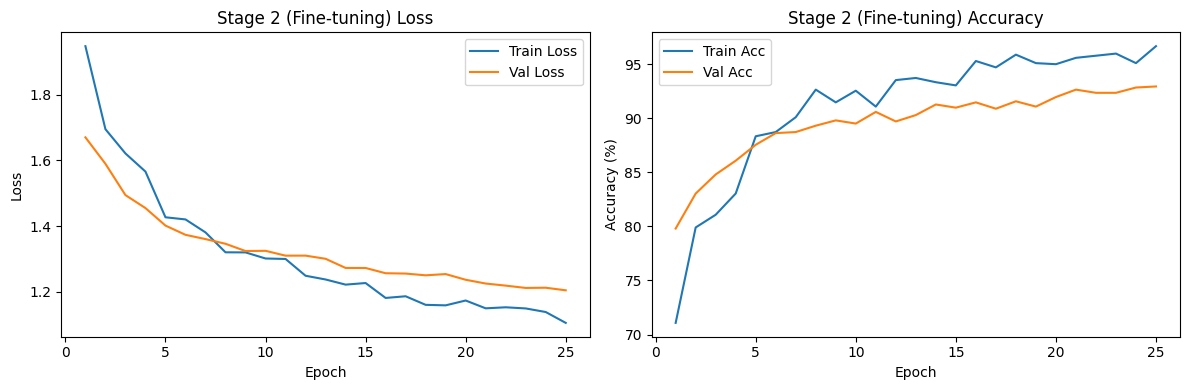

In [ ]:
def plot_history(history, title_prefix="Stage 1"):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title_prefix} Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{title_prefix} Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_stage1, "Stage 1 (Frozen features)")
plot_history(history_stage2, "Stage 2 (Fine-tuning)")

## Interactive Demo

A Streamlit application (`app.py`) has been generated and deployed using `ngrok`, allowing for interactive flower classification. You can upload an image of a flower, and the application will predict its species, showing the top 3 probabilities, and importantly, visualizing the Grad-CAM heatmap to indicate the model's focus area for the top prediction.

**To access the demo, click on the URL provided in the output of the last code cell.**

In [ ]:
%%writefile app.py
import streamlit as st
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.cm as cm

# --- Config ---
st.set_page_config(page_title="FloraScan AI", layout="centered")

# --- Oxford Flowers 102 labels ---
LABELS = [
    'pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold',
    'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle',
    'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris',
    'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily',
    'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth',
    'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william',
    'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly',
    'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose',
    'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue',
    'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion',
    'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium',
    'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia?',
    'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy',
    'osteospermum', 'spring crocus', 'bearded iris', 'windflower', 'tree poppy',
    'gazania', 'azalea', 'water lily', 'rose', 'thorn apple',
    'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium',
    'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose',
    'tree mallow', 'magnolia', 'cyclamen', 'watercress', 'canna lily',
    'hippeastrum', 'bee balm', 'ball moss', 'foxglove', 'bougainvillea',
    'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower',
    'trumpet creeper', 'blackberry lily'
]

# --- Preprocessing ---
def process_image(image: Image.Image) -> torch.Tensor:
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    return transform(image).unsqueeze(0)

# --- Model + Grad-CAM Hooks ---
@st.cache_resource
def load_model_with_hooks():
    device = torch.device("cpu")
    model = models.resnet34(weights=None)
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 102)
    )

    # Prefer fine-tuned model if available
    try:
        state_dict = torch.load("flower_model_best_finetuned.pth", map_location=device)
    except:
        state_dict = torch.load("flower_model_best_stage1.pth", map_location=device)

    model.load_state_dict(state_dict)
    model.eval()

    activations = {}
    gradients = {}

    def forward_hook(module, inp, out):
        activations["value"] = out.detach()

    def backward_hook(module, grad_in, grad_out):
        gradients["value"] = grad_out[0].detach()

    # Use layer4 for Grad-CAM
    target_layer = model.layer4
    target_layer.register_forward_hook(forward_hook)
    target_layer.register_full_backward_hook(backward_hook)

    model._gradcam_activations = activations
    model._gradcam_gradients = gradients
    return model


def generate_gradcam(model, img_tensor, class_idx: int):
    """
    img_tensor: (1,3,224,224)
    class_idx: int (target class)
    """
    model.zero_grad()
    output = model(img_tensor)
    score = output[0, class_idx]
    score.backward()

    activations = model._gradcam_activations["value"][0]  # (C,H,W)
    gradients = model._gradcam_gradients["value"][0]      # (C,H,W)

    # Global average pooling on gradients
    weights = gradients.mean(dim=(1, 2))                  # (C,)

    cam = torch.zeros(activations.shape[1:], dtype=torch.float32)
    for w, a in zip(weights, activations):
        cam += w * a

    cam = torch.relu(cam)
    if cam.max() > 0:
        cam -= cam.min()
        cam /= cam.max()

    return cam.detach().cpu().numpy()  # (H,W) in [0,1]


def overlay_heatmap_on_image(img: Image.Image, cam: np.ndarray, alpha: float = 0.4) -> Image.Image:
    cam_resized = Image.fromarray((cam * 255).astype(np.uint8)).resize(img.size, resample=Image.BILINEAR)
    cam_resized = np.array(cam_resized) / 255.0

    heatmap = cm.jet(cam_resized)[..., :3]  # RGB
    heatmap = (heatmap * 255).astype(np.uint8)
    heatmap_img = Image.fromarray(heatmap)

    blended = Image.blend(img.convert("RGB"), heatmap_img, alpha)
    return blended


# --- UI Layout ---
st.title("🌺 FloraScan: AI Botanist with Grad-CAM")
st.write("Upload a flower image to identify its species and see **where** the model is looking.")

uploaded_file = st.file_uploader("Choose a flower image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file).convert("RGB")

    col1, col2 = st.columns(2)
    with col1:
        st.image(image, caption=f"Uploaded: {uploaded_file.name}", width=350)

    model = load_model_with_hooks()

    if st.button("🔍 Analyze Flower"):
        with st.spinner("Identifying species and computing Grad-CAM..."):
            img_tensor = process_image(image)
            img_tensor.requires_grad_(True)

            # Forward pass
            outputs = model(img_tensor)
            probs = torch.softmax(outputs, dim=1)
            top_p, top_class = probs.topk(3, dim=1)

            top_p = top_p.detach().numpy()[0]
            top_class = top_class.detach().numpy()[0].astype(int)

            best_idx = int(top_class[0])
            best_name = LABELS[best_idx].title()
            best_conf = top_p[0] * 100.0

            # Grad-CAM for the best prediction
            cam = generate_gradcam(model, img_tensor, best_idx)
            overlay = overlay_heatmap_on_image(image, cam, alpha=0.45)

        st.success(f"Best Match: **{best_name}** ({best_conf:.2f}%)")

        with col2:
            st.image(overlay, caption="Grad-CAM Focus Region", width=350)

        # Show top-3 predictions
        st.subheader("Top 3 Predictions")
        for p, c in zip(top_p, top_class):
            st.write(f"- **{LABELS[int(c)].title()}** — {p * 100:.2f}%")


Overwriting app.py


In [ ]:
from pyngrok import ngrok

# 1. Set your auth token
NGROK_AUTH_TOKEN = "36fghwuOtSRK9VzzEliLeq5jp5r_6svFaKzTWaMj1jxnsjzAG"  # <--- PASTE YOUR TOKEN HERE
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# 2. Kill any existing tunnels
ngrok.kill()

# 3. Run Streamlit in the background
import subprocess
process = subprocess.Popen(['streamlit', 'run', 'app.py'])

# 4. Open the Tunnel
try:
    public_url = ngrok.connect(8501).public_url
    print(f"🚀 App is live at: {public_url}")
except Exception as e:
    print(f"Error starting ngrok: {e}")

🚀 App is live at: https://unsecreted-kyung-nonsentiently.ngrok-free.dev


In [ ]:
def topk_accuracy(model, dataloader, k=3):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            _, topk = out.topk(k, dim=1)
            correct += (topk == y.unsqueeze(1)).any(dim=1).sum().item()
            total += y.size(0)

    return correct / total


In [ ]:
print("Top-1 Acc:", topk_accuracy(model, dataloaders['test'], k=1))
print("Top-3 Acc:", topk_accuracy(model, dataloaders['test'], k=3))
print("Top-5 Acc:", topk_accuracy(model, dataloaders['test'], k=5))


Top-1 Acc: 0.9029110424459261
Top-3 Acc: 0.9591803545291917
Top-5 Acc: 0.9749552772808586
